In [2]:
import keras
import matplotlib.pyplot as plt
import keras,os
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.models import Sequential
from keras.layers import Activation, BatchNormalization, Dense, Conv2D, MaxPool2D , Flatten
from keras.preprocessing.image import ImageDataGenerator
import numpy as np
import os
import numpy as np
from joblib import dump
from sklearn.svm import SVC, LinearSVC
from sklearn.metrics import accuracy_score
from sklearn.model_selection import StratifiedKFold
from keras.models import Sequential, Model
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import GlobalAveragePooling2D, GlobalMaxPooling2D
from keras.applications.vgg16 import VGG16
import matplotlib.pyplot as plt
from PIL import ImageFile


ImageFile.LOAD_TRUNCATED_IMAGES = True
input_size=(416, 416)
batch_size=6

# define image height and width
img_height = 416
img_width = 416
channels = 3

# define image generator without augmentation
train = "./SnipDat/Train/"
val = "./SnipDat/Val/"

trdata = ImageDataGenerator(rescale=1./255)
traindata = trdata.flow_from_directory(directory=train, target_size=(img_height, img_width))

tsdata = ImageDataGenerator(rescale=1./255)
testdata = tsdata.flow_from_directory(directory=val, target_size=(img_height, img_width))

Using TensorFlow backend.


Found 705 images belonging to 11 classes.
Found 177 images belonging to 11 classes.


Found 705 images belonging to 11 classes.


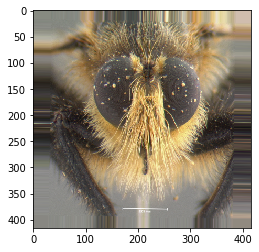

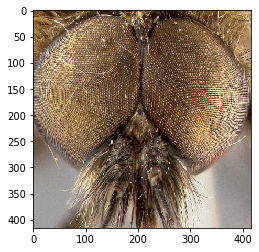

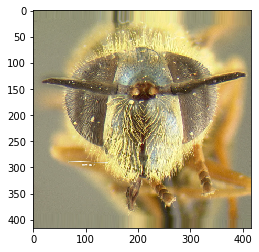

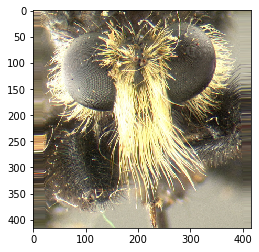

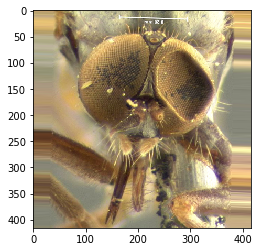

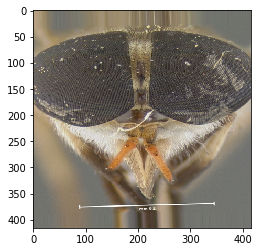

In [5]:
datagen = ImageDataGenerator(rescale=1./255)

train_generator = datagen.flow_from_directory(
    train,
    color_mode = "rgb",
    target_size=(img_height, img_width),
    batch_size=1,
    class_mode='sparse')

# i = 0
# img_list = []
# for batch in train_generator: #.flow(x, batch_size=1)
#     img_list.append(batch)
#     i += 1
#     if i > 5:
#         break
#         
# 
# for img in img_list:
#     plt.imshow(np.squeeze(img))
#     plt.show()


In [6]:

from sklearn.calibration import CalibratedClassifierCV

batch_size = 8
train_generator = datagen.flow_from_directory(
    train,
    color_mode = "rgb",
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='sparse')

x_train, y_train = next(train_generator)
x_test, y_test = next(train_generator)

from sklearn.linear_model import LogisticRegression
logistic = LogisticRegression()

logistic.fit(x_train.reshape(batch_size,-1), y_train)

ly_pred = logistic.predict(x_test.reshape(len(x_test), -1))

print(ly_pred[:10])
logistic.predict_proba(x_test[:3].reshape(3,-1))
np.count_nonzero(ly_pred == y_test)/len(y_test)


Found 705 images belonging to 11 classes.


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


[10. 10. 10. 10.  1.  1.  3.  0. 10.  3.]


0.28125

In [7]:
clf = CalibratedClassifierCV(LinearSVC(C=1.0, loss='squared_hinge', penalty='l2', multi_class='ovr'))

clf.fit(x_train.reshape(batch_size, -1), y_train)

cy_pred = clf.predict(x_test.reshape(len(x_test), -1))

print(cy_pred[:10])

clf.predict_proba(x_test[:3].reshape(3,-1))

np.count_nonzero(cy_pred == y_test)/len(y_test)

/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:657: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of members in any class cannot be less than n_splits=3.
  % (min_groups, self.n_splits)), Warning)


[10. 10. 10. 10.  1. 10. 10.  0. 10.  3.]


0.28125

In [8]:
model = Sequential()

model.add(Conv2D(8, kernel_size=(3,3), padding='same', input_shape = (img_width, img_height, channels)))
model.add(Activation('relu'))
model.add(MaxPool2D(pool_size=(3, 3)))

model.add(Conv2D(16, kernel_size=(3,3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPool2D(pool_size=(2, 2)))

model.add(Conv2D(32, kernel_size=(3,3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPool2D(pool_size=(2, 2)))

model.add(Conv2D(32, kernel_size=(3,3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPool2D(pool_size=(2, 2)))

model.add(Flatten())
model.add(Dense(1, activation='sigmoid'))
model.compile(optimizer='adadelta', loss='binary_crossentropy', metrics=['accuracy'])

model.summary()

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 416, 416, 8)       224       
_________________________________________________________________
activation_1 (Activation)    (None, 416, 416, 8)       0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 138, 138, 8)       0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 138, 138, 16)      1168      
_________________________________________________________________
batch_normalization_1 (Batch (None, 138, 138, 16)      64        
_________________________________________________________________
activation_2 (Activation)    (None, 138, 138, 16)      0         
__________________________

In [9]:
batch_size = 32
train_generator = datagen.flow_from_directory(
    train,
    color_mode = "rgb",
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='sparse')

model.fit_generator(train_generator, 705//batch_size, epochs=10)

Found 705 images belonging to 11 classes.
Epoch 1/10
22/22 [==============================] - 47s 2s/step - loss: -719.2506 - accuracy: 0.1189
Epoch 2/10
22/22 [==============================] - 37s 2s/step - loss: -4230.7460 - accuracy: 0.1218
Epoch 3/10
22/22 [==============================] - 34s 2s/step - loss: -16350.3759 - accuracy: 0.1204
Epoch 4/10
22/22 [==============================] - 30s 1s/step - loss: -59251.0437 - accuracy: 0.1144
Epoch 5/10
22/22 [==============================] - 31s 1s/step - loss: -199840.3179 - accuracy: 0.1129
Epoch 6/10
22/22 [==============================] - 31s 1s/step - loss: -579817.0142 - accuracy: 0.1122
Epoch 7/10
22/22 [==============================] - 32s 1s/step - loss: -1326939.8954 - accuracy: 0.1293
Epoch 8/10
22/22 [==============================] - 31s 1s/step - loss: -4007421.6871 - accuracy: 0.1025
Epoch 9/10
22/22 [==============================] - 31s 1s/step - loss: -7499917.2448 - accuracy: 0.1308
Epoch 10/10
22/22 [=======

In [22]:
batch_size = 1
test2_generator = datagen.flow_from_directory(
    val,
    color_mode = "rgb",
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='sparse', 
    shuffle=False)

y_pred = model.predict_generator(test2_generator, 177//batch_size, workers=4)
for i in y_pred[:10]:
    print(float(i))
model.predict_classes(x_test)
print(np.count_nonzero(y_pred == y_test)/len(y_test))

Found 177 images belonging to 11 classes.
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
38.71875


Asilidae/Ablautus_mimus_Asilidae_Ablautus.jpg [1.]
Asilidae/Broticosia_rapax_Asilidae_Broticosia.jpg [1.]
Asilidae/Cophura_nephressa_Asilidae_Cophura.jpg [1.]
Asilidae/Cyrtopogon_aurifex_Asilidae_Cyrtopogon.jpg [1.]
Asilidae/Cyrtopogon_evidens_Asilidae_Cyrtopogon.jpg [1.]
Asilidae/Cyrtopogon_leucozona_Asilidae_Cyrtopogon.jpg [1.]
Asilidae/Cyrtopogon_marginalis_Asilidae_Cyrtopogon.jpg [1.]
Asilidae/Cyrtopogon_melanopleurus_Asilidae_Cyrtopogon.jpg [1.]
Asilidae/Cyrtopogon_nugator_Asilidae_Cyrtopogon.jpg [1.]
Asilidae/Cyrtopogon_plausor_Asilidae_Cyrtopogon.jpg [1.]
Asilidae/Dasyllis_macquarti_Asilidae_Dasyllis.jpg [1.]
Asilidae/Deromyia_bilineata_Asilidae_Deromyia.jpg [1.]
Asilidae/Deromyia_discolor_Asilidae_Deromyia.jpg [1.]
Asilidae/Dioctria_brevis_Asilidae_Dioctria.jpg [1.]
Asilidae/Dioctria_flavipes_Asilidae_Dioctria.jpg [1.]
Asilidae/Dioctria_propinqua_Asilidae_Dioctria.jpg [1.]
Asilidae/Dioctria_resplendens_Asilidae_Dioctria.jpg [1.]
Asilidae/Diogmites_angustipennis_Asilidae_Diogmit

In [4]:
model2 = VGG16(weights='imagenet', include_top=False)  

c1 = model2.layers[-16].output
c1 = GlobalAveragePooling2D()(c1)

c2 = model2.layers[-13].output
c2 = GlobalAveragePooling2D()(c2)

c3 = model2.layers[-9].output
c3 = GlobalAveragePooling2D()(c3)

c4 = model2.layers[-5].output
c4 = GlobalAveragePooling2D()(c4)

c5 = model2.layers[-1].output
c5 = GlobalAveragePooling2D()(c5)

model2 = Model(inputs=model2.input, outputs=(c1, c2, c3, c4, c5))

model2.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, None, None, 3 0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, None, None, 6 1792        input_1[0][0]                    
__________________________________________________________________________________________________
block1_conv2 (Conv2D)           (None, None, None, 6 36928       block1_conv1[0][0]               
__________________________________________________________________________________________________
block1_pool (MaxPooling2D)      (None, None, None, 6 0           block1_conv2[0][0]               
____________________________________________________________________________________________

In [ ]:
batch_size = 32
datagen = ImageDataGenerator(rescale=1. / 255.)

generator2 = datagen.flow_from_directory(
    train,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode="sparse",
    shuffle=False)

# generate and save features, labels and respective filenames
steps = 705 / 32
X = model2.predict_generator(generator2, steps)
Y = np.concatenate([generator2.next()[1] for i in range(0, generator2.samples, batch_size)])
names = generator2.filenames

Found 705 images belonging to 11 classes.


In [ ]:
checkpoint = ModelCheckpoint(
    "vgg16_1.h5",
    monitor='val_acc',
    verbose=1,
    save_best_only=True,
    save_weights_only=False,
    mode='auto',
    period=1)

early = EarlyStopping(
    monitor='val_acc',
    min_delta=0,
    patience=20,
    verbose=1,
    mode='auto')

hist = model.fit_generator(
    steps_per_epoch=100,
    generator=traindata,
    validation_data=testdata,
    validation_steps=10,
    epochs=100,
    callbacks=[checkpoint, early])

In [ ]:
import matplotlib.pyplot as plt
plt.plot(hist.history["acc"])
plt.plot(hist.history['val_acc'])
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title("model accuracy")
plt.ylabel("Accuracy")
plt.xlabel("Epoch")
plt.legend(["Accuracy", "Validation Accuracy", "loss", "Validation Loss"])
plt.show()

from keras.preprocessing import image
img = image.load_img("./SnipDat/Test/test1.jpg", target_size=(416, 416))
img = np.asarray(img)
plt.imshow(img)
img = np.expand_dims(img, axis=0)

from keras.models import load_model
saved_model = load_model("vgg16_1.h5")
output = saved_model.predict(img)

if output[0][0] > output[0][1]:
    print("cat")
else:
    print('dog')